<a href="https://colab.research.google.com/github/YashGadhia/Convolutional_Neural_Network/blob/master/MNIST_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torchvision import datasets, transforms
from skimage.transform import rotate
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
print(sys.version)
device='cuda'

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

3.6.9 (default, Nov  7 2019, 10:44:02) 
[GCC 8.3.0]
CUDA is available!  Training on GPU ...


In [0]:
df=pd.read_csv("/content/drive/My Drive/Colab Notebooks/MNIST/train.csv")
#train=torch.from_numpy(df.values)
train=df.values
x_train=(train[:,1:]).astype(np.float32)#.to(device)
y_train=(train[:,0])#.to(device)

df_test=pd.read_csv("/content/drive/My Drive/Colab Notebooks/MNIST/test.csv")
x_test=df_test.values.astype(np.float32)

del df,train,df_test

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)

(42000, 784)
(42000,)
(28000, 784)


In [0]:
random_seed = 1
x_train, x_cv, y_train, y_cv = train_test_split(x_train, y_train, test_size = 7000, random_state = random_seed)

print(x_train.shape)
print(x_train.dtype)
print(x_cv.shape)
print(y_train.shape)
print(y_cv.shape)

(35000, 784)
float32
(7000, 784)
(35000,)
(7000,)


In [0]:
X_train = []
Y_train = []
np.random.seed(1)
rot_angle = 40*np.random.random_sample([x_train.shape[0],4])
for i in range(x_train.shape[0]):
    X_train.append(x_train[i])
    for j in range(4):
      X_train.append(rotate(x_train[i].reshape((28,28)),angle=rot_angle[i,j],mode='wrap').reshape((784))) 
    for j in range(5):
      Y_train.append(y_train[i])

X_train = np.asarray(X_train,dtype=np.float32)
Y_train = np.asarray(Y_train)
print(X_train.shape)
print(Y_train.shape)

del x_train,y_train

(175000, 784)
(175000,)


7


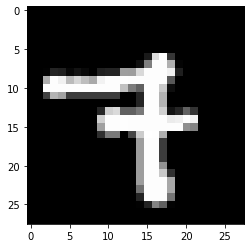

In [0]:
index = 5
print(Y_train[index])
plt.imshow(X_train[index].reshape((28,28)), cmap='gray')

7


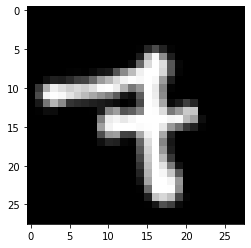

In [0]:
print(Y_train[index+1])
plt.imshow(X_train[index+1].reshape((28,28)), cmap='gray')

In [0]:
X_train = X_train/255.0
x_cv = x_cv/255.0
final_Xtrain = torch.from_numpy(X_train.reshape(-1,1,28,28)).to(device)
final_Ytrain = torch.from_numpy(Y_train.squeeze()).to(device)

final_Xcv = torch.from_numpy(x_cv.reshape(-1,1,28,28)).to(device)
final_Ycv = torch.from_numpy(y_cv.squeeze()).to(device)

print(final_Xtrain.size())
print(final_Ytrain.size())
print(final_Xcv.size())
print(final_Ycv.size())

torch.Size([175000, 1, 28, 28])
torch.Size([175000])
torch.Size([7000, 1, 28, 28])
torch.Size([7000])


In [0]:
train_ds = TensorDataset(final_Xtrain,final_Ytrain)
cv_ds = TensorDataset(final_Xcv,final_Ycv)

train_dl = DataLoader(train_ds,batch_size=64,shuffle=True)
cv_dl = DataLoader(cv_ds,batch_size=64,shuffle=True)

In [0]:
class MNIST_CNN(nn.Module):
  def __init__(self):
    super(MNIST_CNN,self).__init__()
    self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2,2))
    self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2,2))
    self.drop1 = nn.Dropout2d(0.4)
    self.lin1 = nn.Linear(7*7*64,128)
    self.norm = nn.BatchNorm1d(128)
    self.drop2 = nn.Dropout(0.4)
    self.lin2 = nn.Linear(128,10)



  def forward(self,xb):
    xb=xb.view(-1,1,28,28)
    xb = self.layer1(xb)
    xb = self.layer2(xb)
    xb = self.drop1(xb)
    xb = torch.flatten(xb,1,3)
    xb = F.relu(self.lin1(xb))
    xb = self.norm(xb)
    xb = self.drop2(xb)
    xb = self.lin2(xb)
    return xb

model = MNIST_CNN()
model.float()
model.to(device)      

MNIST_CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop1): Dropout2d(p=0.4, inplace=False)
  (lin1): Linear(in_features=3136, out_features=128, bias=True)
  (norm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop2): Dropout(p=0.4, inplace=False)
  (lin2): Linear(in_features=128, out_features=10, bias=True)
)

Epoch No. = 0 cost = 277.07891845703125
Training Accuracy =  0.970441042047532
Validation Accuracy =  0.984280303030303
Epoch No. = 1 cost = 131.48568725585938
Training Accuracy =  0.9851481566118221
Validation Accuracy =  0.9876893939393939
Epoch No. = 2 cost = 95.70906066894531
Training Accuracy =  0.988933957952468
Validation Accuracy =  0.990625
Epoch No. = 3 cost = 79.04429626464844
Training Accuracy =  0.9908535191956125
Validation Accuracy =  0.9911931818181818
Epoch No. = 4 cost = 66.60572814941406
Training Accuracy =  0.9923046160877513
Validation Accuracy =  0.9912405303030303
Epoch No. = 5 cost = 57.052589416503906
Training Accuracy =  0.9932034582571603
Validation Accuracy =  0.9921875
Epoch No. = 6 cost = 52.66319274902344
Training Accuracy =  0.9936128884826325
Validation Accuracy =  0.9914772727272727
Epoch No. = 7 cost = 47.00619888305664
Training Accuracy =  0.9943403412553322
Validation Accuracy =  0.9920454545454546
Epoch No. = 8 cost = 43.26169204711914
Training Acc

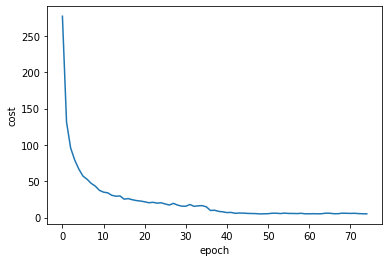

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1, verbose=True, eps=1e-09)

epochs = 75
costs = []

for epoch in range(epochs):
  total_loss = 0
  train_acc = 0
  model.train()
  for (x,y) in train_dl:
    x.to(device)
    y.to(device)
    Ypred = model(x.float())
    Ypred.to(device)
    loss = criterion(Ypred,y)
    total_loss = total_loss + loss
    Ypred_binary = torch.argmax(Ypred, keepdim= False, dim=1)
    train_acc = train_acc + accuracy_score(y.cpu(),Ypred_binary.cpu())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  costs.append(total_loss)
  print("Epoch No. = "+ str(epoch), "cost = "+str(costs[epoch].item()))
  print("Training Accuracy = ", train_acc/len(train_dl))
  lr_scheduler.step(total_loss/len(train_dl))

  model.eval()
  with torch.no_grad():
    cv_acc = 0
    for x_val,y_val in cv_dl:
      x_val.to(device)
      y_val.to(device)
      Ypred_val = model(x_val.float())
      Ypred_val.to(device)
      Ypred_val_binary = torch.argmax(Ypred_val, keepdim= False, dim=1)
      cv_acc = cv_acc + accuracy_score(y_val.cpu(),Ypred_val_binary.cpu())
    print("Validation Accuracy = ", cv_acc/len(cv_dl))

plt.plot(costs)
plt.ylabel("cost")
plt.xlabel("epoch")
plt.show()      

In [0]:
x_test = x_test/255.0
x_test = x_test.reshape(-1,1,28,28)
print(x_test.shape)
x_test = torch.from_numpy(x_test).to(device)

model.eval()
with torch.no_grad():
  Ypred_test = model(x_test.float()).cpu()
  Ypred_test_binary = torch.argmax(Ypred_test, keepdim= False, dim=1).cpu().numpy()
  print(Ypred_test_binary.shape)

(28000, 1, 28, 28)
torch.Size([28000])


In [0]:
ImageId = np.arange(1,28001)
data = {"ImageId":ImageId,"Label":Ypred_test_binary}
test_predictions = pd.DataFrame(data)
test_predictions.to_csv('Test_Predict.csv',index=False)
print(test_predictions)

       ImageId  Label
0            1      2
1            2      0
2            3      9
3            4      0
4            5      3
...        ...    ...
27995    27996      9
27996    27997      7
27997    27998      3
27998    27999      9
27999    28000      2

[28000 rows x 2 columns]
